## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight')
from time import time
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



## 0. Get data ready

Import data and drop NA's, because I don't want to play in imputation of missing data this time.

In [2]:
ctr = pd.read_csv("data/countries.csv", encoding='utf-8')
df = pd.read_csv("data/athletes.csv", encoding='utf-8', decimal='.', parse_dates=['dob'], index_col=0).dropna()
df.head()

,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
id,,,,,,,,,,
736041664,A Jesus Garcia,ESP,male,2069-10-17,1.72,64.0,athletics,0,0,0
532037425,A Lam Shin,KOR,female,1986-09-23,1.68,56.0,fencing,0,0,0
435962603,Aaron Brown,CAN,male,1992-05-27,1.98,79.0,athletics,0,0,1
521041435,Aaron Cook,MDA,male,1991-01-02,1.83,80.0,taekwondo,0,0,0
33922579,Aaron Gate,NZL,male,1990-11-26,1.81,71.0,cycling,0,0,0


In [3]:
df[['gold', 'silver', 'bronze']].sum()

gold      649
silver    635
bronze    636
dtype: int64

### Get some outlook on the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 736041664 to 711404576
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   name         10858 non-null  object        
 1   nationality  10858 non-null  object        
 2   sex          10858 non-null  object        
 3   dob          10858 non-null  datetime64[ns]
 4   height       10858 non-null  float64       
 5   weight       10858 non-null  float64       
 6   sport        10858 non-null  object        
 7   gold         10858 non-null  int64         
 8   silver       10858 non-null  int64         
 9   bronze       10858 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 933.1+ KB


In [5]:
df.describe(include='all')

C:\Users\jp_ko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
count,10858,10858,10858,10858,10858.000000,10858.000000,10858,10858.000000,10858.000000,10858.000000
unique,10840,200,2,5453,NaN,NaN,27,NaN,NaN,NaN
top,Gabriella Szucs,USA,male,1993-02-18 00:00:00,NaN,NaN,athletics,NaN,NaN,NaN
freq,2,552,5862,9,NaN,NaN,2187,NaN,NaN,NaN
first,NaN,NaN,NaN,1971-03-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2070-12-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.766942,72.070915,NaN,0.059772,0.058482,0.058574
std,NaN,NaN,NaN,NaN,0.113111,16.162358,NaN,0.260756,0.242387,0.239113
min,NaN,NaN,NaN,NaN,1.210000,31.000000,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,1.690000,60.000000,NaN,0.000000,0.000000,0.000000


## Prepare features
### Age
Transform date of birth to age in years and display histogram.

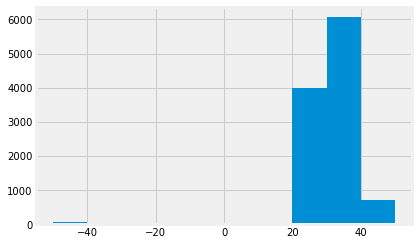

In [6]:
df['Age'] = round(((pd.to_datetime('today') - df['dob']).dt.days) / 365 , 0)
df['Age'].hist()

In [7]:
df[df['Age'] < 0].head()

,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,Age
id,,,,,,,,,,,
736041664,A Jesus Garcia,ESP,male,2069-10-17,1.72,64.0,athletics,0,0,0,-48.0
189886442,Abdelkebir Ouaddar,MAR,male,2062-07-15,1.74,67.0,equestrian,0,0,0,-41.0
969824503,Abdullah Alrashidi,IOA,male,2063-08-21,1.83,84.0,shooting,0,0,1,-42.0
794799982,Alex Cejka,GER,male,2070-12-02,1.68,65.0,golf,0,0,0,-50.0
54828663,Andrey Mitin,RUS,male,2070-04-05,1.74,80.0,equestrian,0,0,0,-49.0


Looks that in some cases date of birth is wrongly read from csv by pandas (like it was year 2050+). Quick internet research confirms that eg. **Abdelkebir Ouaddar** was born in 1962 instead of 2062. Let's fix this mistake for all athlete's.

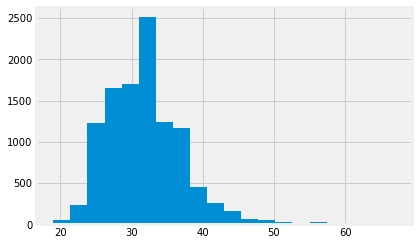

In [8]:
df['Age'] = np.where(df['Age'] < 0, df['Age'] + 100, df['Age'])
df['Age'].hist(bins=20)

Looks correct now.

### Medal - target variable
I will add information whether athlete won any medals or not, no matter what colour the medal was. This is going to be my binary target variable.

In [9]:
df['medal'] = np.where(df['gold'] + df['silver'] + df['bronze'] > 0, 1, 0)

### Country - continent
There is too many categories in the nationality column, so I will grouby them by continents. To group countries by continents I will need to map them. List of countries with continents: https://gist.github.com/mlisovyi/e8df5c907a8250e14cc1e5933ed53ffd

In [11]:
cont = pd.read_excel('data/continents.xlsx', engine='openpyxl')
cont.head()

,capital,code,continent,name,timezones
0,Andorra la Vella,AD,Europe,Andorra,['Europe/Andorra']
1,Kabul,AF,Asia,Afghanistan,['Asia/Kabul']
2,St. John's,AG,North America,Antigua and Barbuda,['America/Antigua']
3,Tirana,AL,Europe,Albania,['Europe/Tirane']
4,Yerevan,AM,Asia,Armenia,['Asia/Yerevan']


Join 'continents' and 'countries' data frames. 

In [12]:
ctr = ctr.merge(cont[['continent', 'name']],
                left_on='country',
                right_on='name',
                how='left')
ctr.head()

,country,code,population,gdp_per_capita,continent,name
0,Afghanistan,AFG,32526562.0,594.323081,Asia,Afghanistan
1,Albania,ALB,2889167.0,3945.217582,Europe,Albania
2,Algeria,ALG,39666519.0,4206.031232,Africa,Algeria
3,American Samoa*,ASA,55538.0,NaN,NaN,NaN
4,Andorra,AND,70473.0,NaN,Europe,Andorra


Let's check if there aren't too many NaN and correct the most significant manually.

In [13]:
ctr[ctr['continent'].isna()==True]

,country,code,population,gdp_per_capita,continent,name
3,American Samoa*,ASA,5.553800e+04,NaN,NaN,NaN
9,Aruba*,ARU,1.038890e+05,NaN,NaN,NaN
20,Bermuda*,BER,6.523500e+04,NaN,NaN,NaN
27,British Virgin Islands,IVB,3.011700e+04,NaN,NaN,NaN
28,Brunei,BRU,4.231880e+05,30554.729666,NaN,NaN
36,Cayman Islands*,CAY,5.996700e+04,NaN,NaN,NaN
40,China,CHN,1.371220e+09,8027.683810,NaN,NaN
43,Congo,CGO,4.620330e+06,1851.199916,NaN,NaN
44,"Congo, Dem Rep",COD,7.726681e+07,456.052741,NaN,NaN
45,Cook Islands,COK,NaN,NaN,NaN,NaN


I will correct only few of these countries, as most of them don't win any medals at the Olympics

In [14]:
ctr.loc[40, 'continent'] = 'Asia'    # China
ctr.loc[43, 'continent'] = 'Africa'  # Congo
ctr.loc[47, 'continent'] = 'Africa'  # Cote d'Ivoire
ctr.loc[81, 'continent'] = 'Asia'    # Hong Kong
ctr.loc[88, 'continent'] = 'Europe'  # Ireland
ctr.loc[96, 'continent'] = 'Asia'    # South Korea
ctr.loc[129, 'continent'] = 'Europe' # Netherlands

In [15]:
df['nationality'].value_counts().head()

USA    552
BRA    466
GER    435
AUS    410
FRA    398
Name: nationality, dtype: int64

Join information about countries to athlete data frame.

In [16]:
df = df.merge(ctr[['code', 'continent', 'population', 'gdp_per_capita']],
              left_on='nationality',
              right_on='code',
              how='left')

### IOC joining date
Import date of joining IOC (International Olimpic Committee) by each country - from Wikipedia.

In [19]:
ioc = pd.read_excel('data/IOC_joining.xlsx', engine='openpyxl')
ioc.head()

,code,IOC_year,country
0,AFG,1936,Afghanistan
1,ALB,1959,Albania
2,ALG,1964,Algeria
3,ASA,1987,American Samoa
4,AND,1975,Andorra


Calculate seniority of countries in the IOC, which was founded in 1894. 

In [20]:
df = df.merge(ioc[['code', 'IOC_year']],
              on='code',
              how='left')
df['IOC_seniority'] = 2019 - df['IOC_year']
df.head()

,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,Age,medal,code,continent,population,gdp_per_capita,IOC_year,IOC_seniority
0,A Jesus Garcia,ESP,male,2069-10-17,1.72,64.0,athletics,0,0,0,52.0,0,ESP,Europe,46418269.0,25831.582305,1924.0,95.0
1,A Lam Shin,KOR,female,1986-09-23,1.68,56.0,fencing,0,0,0,35.0,0,KOR,NaN,50617045.0,27221.524051,1947.0,72.0
2,Aaron Brown,CAN,male,1992-05-27,1.98,79.0,athletics,0,0,1,29.0,1,CAN,North America,35851774.0,43248.529909,1907.0,112.0
3,Aaron Cook,MDA,male,1991-01-02,1.83,80.0,taekwondo,0,0,0,30.0,0,MDA,Europe,3554150.0,1848.061804,1993.0,26.0
4,Aaron Gate,NZL,male,1990-11-26,1.81,71.0,cycling,0,0,0,31.0,0,NZL,Oceania,4595700.0,37807.967276,1919.0,100.0


### Preparing final dataset
Encoding categorical variables with [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f).

In [21]:
df = pd.concat([df,
                pd.get_dummies(df['sex'], drop_first=False),
                pd.get_dummies(df['continent'], drop_first=False)], axis=1)
df.head()

,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,...,IOC_year,IOC_seniority,female,male,Africa,Asia,Europe,North America,Oceania,South America
0,A Jesus Garcia,ESP,male,2069-10-17,1.72,64.0,athletics,0,0,0,...,1924.0,95.0,0,1,0,0,1,0,0,0
1,A Lam Shin,KOR,female,1986-09-23,1.68,56.0,fencing,0,0,0,...,1947.0,72.0,1,0,0,0,0,0,0,0
2,Aaron Brown,CAN,male,1992-05-27,1.98,79.0,athletics,0,0,1,...,1907.0,112.0,0,1,0,0,0,1,0,0
3,Aaron Cook,MDA,male,1991-01-02,1.83,80.0,taekwondo,0,0,0,...,1993.0,26.0,0,1,0,0,1,0,0,0
4,Aaron Gate,NZL,male,1990-11-26,1.81,71.0,cycling,0,0,0,...,1919.0,100.0,0,1,0,0,0,0,1,0


Let's drop encoded categorical columns and the rest which is unnecessary.

In [22]:
df2 = df.drop(['name', 'dob', 'sex', 'sport', 'continent', 'nationality',
               'code', 'IOC_year', 'gold', 'silver', 'bronze'], axis=1).dropna()
df2.columns

Index(['height', 'weight', 'Age', 'medal', 'population', 'gdp_per_capita',
       'IOC_seniority', 'female', 'male', 'Africa', 'Asia', 'Europe',
       'North America', 'Oceania', 'South America'],
      dtype='object')

## Exploratory Analysis

### Distributions

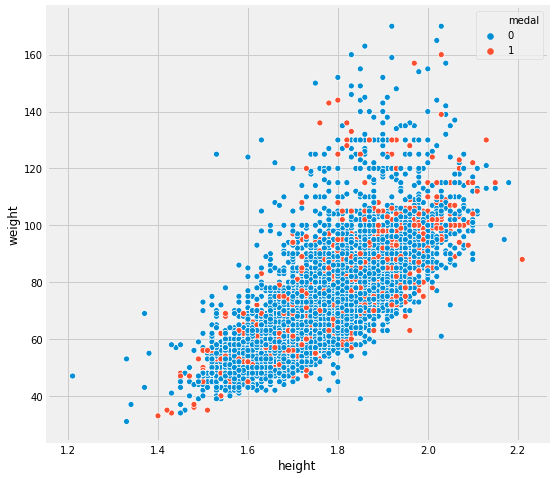

In [23]:
plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
sns.scatterplot(x='height', y='weight', data=df, hue='medal')

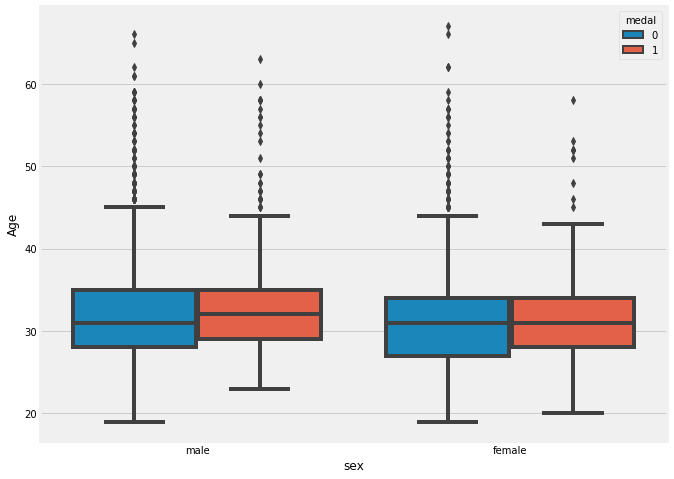

In [24]:
plt.figure(figsize=(10, 8), facecolor='w', edgecolor='k')
sns.boxplot(x='sex', y='Age', data=df, hue='medal')

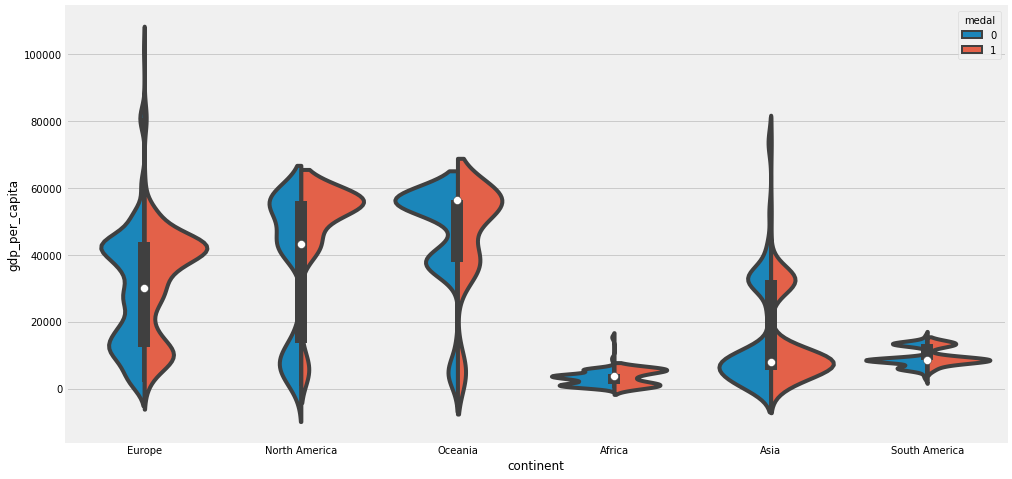

In [25]:
plt.figure(figsize=(15, 8), facecolor='w', edgecolor='k')
sns.violinplot(x='continent', y='gdp_per_capita', data=df, hue='medal', split=True)

This beautifully named violin plot shows that most of medals (red peaks) gain countries with high GDP per capita in North America and Oceania, a little lower in Europe and rather low in Africa, Asia and South America. This dependence is not suprising nor informative, as it generally presents GDP per capita distribution among continents. 

<Figure size 576x576 with 0 Axes>

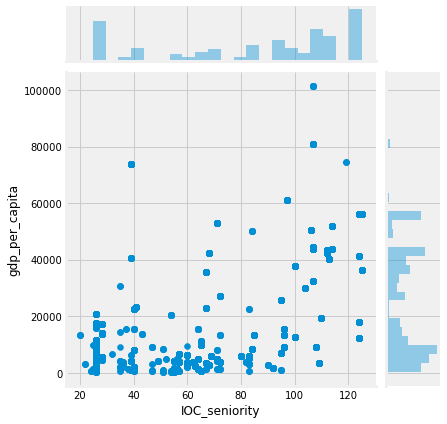

In [26]:
plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
sns.jointplot(x='IOC_seniority', y='gdp_per_capita', data=df2)

### Correlation heatmap.

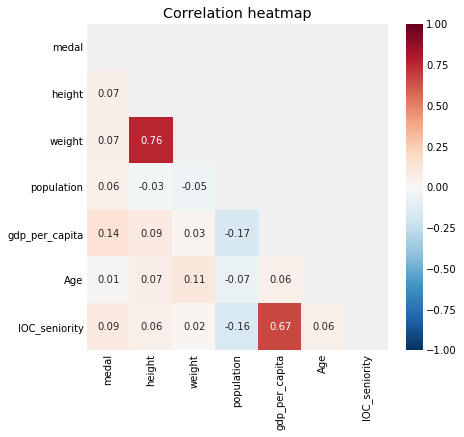

In [27]:
plt.figure(figsize=(6, 6))
corr_matrix2 = round(df2[['medal', 'height', 'weight', 'population', 'gdp_per_capita',
                          'Age', 'IOC_seniority']].corr(), 2)
mask = np.zeros_like(corr_matrix2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.title('Correlation heatmap')
sns.heatmap(corr_matrix2, center=0, vmin=-1, vmax=1, annot=True, cmap="RdBu_r", mask=mask)

Correlation heatmap confirms what was presented in the distributions above. Height is clearly correlated with weight. For further usage in modelling one of them should be removed. Also gdp_per_capita is quite correlated with IOC_seniority, but it is less than 70% so I think I will keep them both.

# 1. Model: Support Vector Classifier

In order to reach best result I will scale data and resample them using under-sampling to get similar number of 0 and 1 in target 'medal' column. Then I will divide dataset into train and test sets.
- approach: [Under-sampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html) 

In [28]:
# 1. Scale data
scaler = StandardScaler()
scaled = scaler.fit_transform(df2.drop(['medal', 'weight'], axis=1))
cols = df2.drop(['medal', 'weight'], axis=1).columns

# 2. Divide into X and y sets
X = pd.DataFrame(scaled, columns=cols)
y = df2['medal']

# 3. Resample data 
RUS = RandomUnderSampler(random_state=765, sampling_strategy=0.75) # because first Olympics are dated to 765 BC
X_res, y_res = RUS.fit_resample(X, y)
X2 = pd.DataFrame(X_res, columns=X.columns)
y2 = y_res

# 4. Divide into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.30, random_state=765)

C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Let's find best parameters of SVM and fit model.

In [29]:
model = SVC()

param_grid = {'C': [0.1,1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
              'kernel': ['rbf']} 

grid = GridSearchCV(estimator = SVC(), param_grid = param_grid, refit=True, verbose=2,
                    scoring='precision', n_jobs=4, iid=False, cv=5)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  1.0min finished
C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=2)

In [30]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


- Predict values for test set

In [31]:
y_pred = grid.best_estimator_.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification stats:\n", classification_report(y_test, y_pred))

Confusion matrix:
 [[652  31]
 [405  68]]

Classification stats:
               precision    recall  f1-score   support

           0       0.62      0.95      0.75       683
           1       0.69      0.14      0.24       473

    accuracy                           0.62      1156
   macro avg       0.65      0.55      0.49      1156
weighted avg       0.65      0.62      0.54      1156



- 65% accuracy is not bad, but let's try do better with another model

# 2. Model: Gradient Boosting Classifier

I will procede on the same train and test datasets as above.

In [32]:
GBC = GradientBoostingClassifier(verbose=0)

param_grid_2 = {'n_estimators': range(50, 100, 10),
               'max_depth': [3, 4, 5, 6],
               'min_samples_split': range(30, 60, 10), 
               'min_samples_leaf': range(20, 50, 10)}

grid_2 = GridSearchCV(estimator = GBC, refit=True, verbose=2,
                      param_grid = param_grid_2,
                      scoring='precision', n_jobs=4, iid=False, cv=5)

grid_2.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 706 tasks      | elapsed:   42.0s
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed:   57.2s finished
C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [33]:
print(grid_2.best_params_)
print(grid_2.best_estimator_)

{'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 50, 'n_estimators': 90}
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=30, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [34]:
y_pred2 = grid_2.best_estimator_.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred2))
print("\nClassification stats:\n", classification_report(y_test, y_pred2))

Confusion matrix:
 [[532 151]
 [195 278]]

Classification stats:
               precision    recall  f1-score   support

           0       0.73      0.78      0.75       683
           1       0.65      0.59      0.62       473

    accuracy                           0.70      1156
   macro avg       0.69      0.68      0.69      1156
weighted avg       0.70      0.70      0.70      1156



- 70% is better. Now let's inspect what are the most impactful features.

1. IOC_seniority (0.226364)
2. height (0.222903)
3. gdp_per_capita (0.221977)
4. population (0.159267)
5. Age (0.098577)
6. female (0.021425)
7. South America (0.015026)
8. Europe (0.010525)
9. male (0.010039)
10. Asia (0.009766)
11. Oceania (0.002173)
12. North America (0.001744)
13. Africa (0.000215)


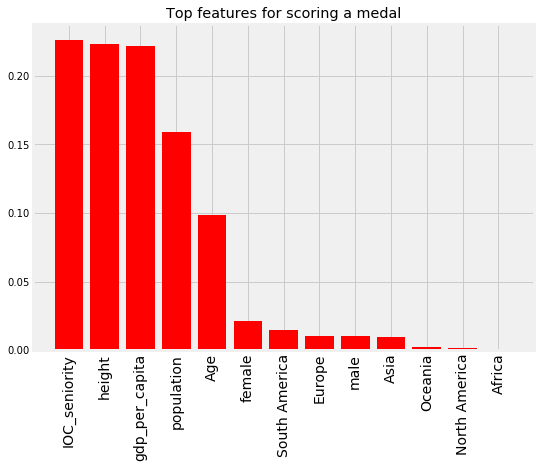

Mean Feature Importance 0.076923 



In [35]:
def report_top_feat(data_set, features, top = 15):
    indices = np.argsort(features)[::-1]
    for f in range(top):
        print("%d. %s (%f)" % (f + 1, data_set.columns[indices[f]], features[indices[f]]))
    
    indices=indices[:top]
    plt.figure(figsize=[8, 6])
    plt.title("Top features for scoring a medal")
    plt.bar(range(top), features[indices], color="r", align="center")
    plt.xticks(range(top), data_set.columns[indices], fontsize=14, rotation=90)
    plt.xlim([-1, top])
#     plt.savefig("Top %d Feature importances for %s.png" % (top, c))
    plt.show()
    print("Mean Feature Importance %.6f" %np.mean(features), '\n')


features = grid_2.best_estimator_.feature_importances_
report_top_feat(X_test, features, X_test.columns.size)

Interesting but intuitive - big and rich countries have more medal winners than the poor ones. Out of features related to athlete himself height and Age are quite important, which is also reasonable. 

# 3. Model: Gradient Boosting Classifier with over-sampling

Let's try the same model just using different resampling method.

In [36]:
sm = SMOTE(random_state=765, sampling_strategy='minority')
X_res, y_res = sm.fit_resample(X, y)
X2 = pd.DataFrame(X_res, columns=X_train.columns)
y2 = y_res

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.30, random_state=765)

C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [37]:
X2.shape, X_train.shape

((16910, 13), (11837, 13))

In [38]:
GBC_2 = GradientBoostingClassifier(verbose=0)

param_grid_3 = {'n_estimators': range(50, 100, 10),
               'max_depth': [3, 4, 5, 6],
               'min_samples_split': range(30, 60, 10), 
               'min_samples_leaf': range(20, 50, 10)}

grid_3 = GridSearchCV(estimator = GBC_2, refit=True, verbose=2,
                      param_grid = param_grid_3,
                      scoring='precision', n_jobs=4, iid=False, cv=5)

grid_3.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed:  4.3min finished
C:\Users\jp_ko\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [39]:
print(grid_3.best_params_)
print(grid_3.best_score_)

{'max_depth': 6, 'min_samples_leaf': 40, 'min_samples_split': 30, 'n_estimators': 90}
0.8866300725465524


In [40]:
y_pred3 = grid_3.best_estimator_.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred3))
print("\nClassification stats:\n", classification_report(y_test, y_pred3))

Confusion matrix:
 [[2288  275]
 [ 457 2053]]

Classification stats:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      2563
           1       0.88      0.82      0.85      2510

    accuracy                           0.86      5073
   macro avg       0.86      0.86      0.86      5073
weighted avg       0.86      0.86      0.86      5073



- 86% is way better! 

1. Age (0.351652)
2. height (0.164245)
3. gdp_per_capita (0.162915)
4. population (0.146558)
5. IOC_seniority (0.136182)
6. male (0.011345)
7. female (0.008454)
8. Europe (0.006733)
9. South America (0.003746)
10. Asia (0.003041)
11. North America (0.002882)
12. Africa (0.001778)
13. Oceania (0.000470)


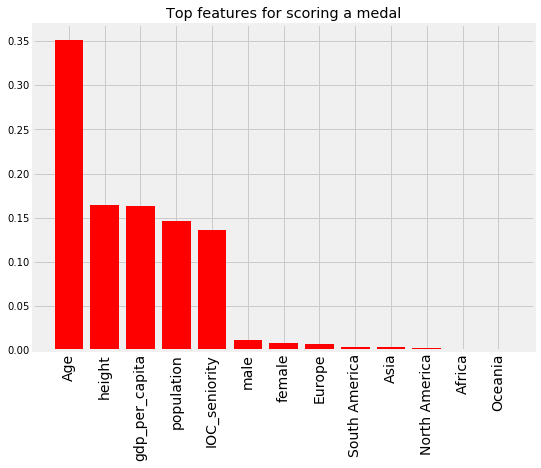

Mean Feature Importance 0.076923 



In [41]:
features = grid_3.best_estimator_.feature_importances_
report_top_feat(X_test, features, X_test.columns.size)

This model shows Age as the most important feature, which is interesting but I leave it to another analysis to inspect why is that. 